# **Workshop #2**

### *EDA - `the_grammy_awards` dataset*
---

## ***Setting the project directory***
This script attempts to change the current working directory to the specified path.
If the directory change fails due to the directory not being found, it prints a message indicating that the user is already in the correct directory.

In [1]:
import os

try:
    os.chdir("../../etl-workshop-2")
except FileNotFoundError:
    print("You are already in the correct directory.")

## ***Importing dependencies***

**Modules:**
* **src.database.db_operations**: Custom module for database operations.

**For this environment we are using:**
* ***Pandas*** >= 2.2.2
* ***matplotlib*** >= 3.9.2
* ***seaborn*** >= 0.13.2

**From the `src.database.db_operations` module, we are also using:**
* ***SQLAlchemy*** >= 2.0.32
    * *SQLAlchemy Utils* >= 0.41.2
* ***python-dotenv*** >= 1.0.1

In [2]:
from src.database.db_operations import creating_engine, disposing_engine
from collections import Counter

import re
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

## ***Reading the data***

In this code block we are in charge of creating the database connection engine. The `creating_engine` function comes from the `src.database.db_operations` module.

In [3]:
engine = creating_engine()

18/09/2024 06:27:39 PM Engine created. You can now connect to the database.


To fetch the data we must read the *grammy_awards_raw* table coming from our PostgreSQL database.

In [4]:
grammys_data = pd.read_sql_table("grammy_awards_raw", engine)
grammys_data.head()

disposing_engine(engine)

18/09/2024 06:27:46 PM Engine disposed.


## ***Data preparation***
---

### **Reviewing the dataset**

The Grammy dataset contains a total of 4.810 entries with 10 columns. The columns provide the following information:

**String columns (object type):**
- `title`: Title of the Grammy nomination.
- `published_at`: Date the nomination was published.
- `updated_at`: Date the nomination was last updated.
- `category`: The Grammy category.
- `nominee`: The person or group nominated.
- `artist`: The artist involved (if applicable).
- `workers`: People involved in the production.
- `img`: URL for an image related to the nomination.

**Numerical columns (int64 type):**
- `year`: The year of the Grammy nomination.

**Boolean column (bool type):**
- `winner`: Indicates if the nominee won the Grammy.

In [5]:
df = grammys_data.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          4810 non-null   int64 
 1   title         4810 non-null   object
 2   published_at  4810 non-null   object
 3   updated_at    4810 non-null   object
 4   category      4810 non-null   object
 5   nominee       4804 non-null   object
 6   artist        2970 non-null   object
 7   workers       2620 non-null   object
 8   img           3443 non-null   object
 9   winner        4810 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 343.0+ KB


### **Checking the unique and null values**

Looking at the results, we noticed something strange in the number of unique values of *winner*, who has only 1 value. This finding will be analyzed in depth later.

In [7]:
df.nunique()

year              62
title             62
published_at       4
updated_at        10
category         638
nominee         4131
artist          1658
workers         2366
img             1463
winner             1
dtype: int64

It is interesting the important amount of null values for *artist* and *workers*, moreover: these columns are the most important in our dataset, because they are the ones that give the most description and value to our record. We will see later how the null values of these two columns could be handled.

In [8]:
df.isnull().sum()

year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist          1840
workers         2190
img             1367
winner             0
dtype: int64

### **Are these columns useful?**

#### **Published At and Updated At column**

In the analysis of the dataset I could not apply a clear use of the values of these two columns. The dates have no relation with the date of the event, or with any ephemeris related to this event. Therefore, I am going to delete them from the dataframe.

In [9]:
df["published_at"].value_counts()

published_at
2017-11-28T00:03:45-08:00    4205
2020-05-19T05:10:28-07:00     433
2018-12-06T23:48:49-08:00      86
2018-05-22T03:08:24-07:00      86
Name: count, dtype: int64

In [10]:
df["updated_at"].value_counts()

updated_at
2019-09-10T01:08:19-07:00    778
2019-09-10T01:06:11-07:00    754
2019-09-10T01:07:37-07:00    713
2019-09-10T01:06:59-07:00    681
2019-09-10T01:11:09-07:00    658
2019-09-10T01:09:02-07:00    554
2020-05-19T05:10:28-07:00    433
2017-11-28T00:03:45-08:00    108
2020-09-01T12:16:40-07:00     83
2019-09-10T01:11:48-07:00     48
Name: count, dtype: int64

#### **Image column**
Let's check if any of these images can be used or are available.

In [11]:
df.loc[0, "img"]

'https://www.grammy.com/sites/com/files/styles/artist_circle/public/muzooka/Billie%2BEilish/Billie%2520Eilish_1_1_1594138954.jpg?itok=3-71Dfxh'

As we see in the output below, many of these images are **no longer available** to the public. This column is of no use whatsoever.

![Billie Elish]("https://www.grammy.com/sites/com/files/styles/artist_circle/public/muzooka/Billie%2BEilish/Billie%2520Eilish_1_1_1594138954.jpg?itok=3-71Dfxh")

#### **Winners column**

We note that the only value available in this column is True, although in some editions the losers in certain categories are also included.

So little information prevents us from differentiating the true winners from the rest of the nominees. Unless we put it together with information that is not related to the Grammys.

In order to differentiate nominated songs from non-nominated songs **at the time of merge** we will leave this column, but rename it to `is_nominated`.

In [12]:
df["winner"].value_counts()

winner
True    4810
Name: count, dtype: int64

In [13]:
df.rename(columns={"winner": "is_nominated"}, inplace=True)

#### **Finally, we remove unnecessary columns**

In [14]:
df = df.drop(columns=["published_at", "updated_at", "img"])

In [15]:
df.head()

,year,title,category,nominee,artist,workers,is_nominated
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",True
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",True
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",True
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",True
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",True


### **Handling of null values**

#### *Nominee*

The *nominee* column only presents 6 null records, which gives us the possibility to further detail its null values and review the possibility of eliminating these rows.

Looking at the null records for *nominee*, it is observed that none of these values actually communicate a specific nominee. Therefore, it does not represent something valuable.

In [16]:
df.loc[df["nominee"].isna()]

,year,title,category,nominee,artist,workers,is_nominated
2274,2000,43rd Annual GRAMMY Awards (2000),"Remixer of the Year, Non-Classical",None,None,None,True
2372,1999,42nd Annual GRAMMY Awards (1999),"Remixer Of The Year, Non-Classical",None,None,None,True
2464,1998,41st Annual GRAMMY Awards (1998),"Remixer Of The Year, Non-classical",None,None,None,True
2560,1997,40th Annual GRAMMY Awards (1997),"Remixer Of The Year, Non-Classical",None,None,None,True
4527,1965,8th Annual GRAMMY Awards (1965),Best New Country & Western Artist,None,None,None,True
4574,1964,7th Annual GRAMMY Awards (1964),Best New Country & Western Artist Of 1964,None,None,None,True


In [17]:
df = df.dropna(subset=["nominee"])
df.loc[df["nominee"].isna()]

,year,title,category,nominee,artist,workers,is_nominated


#### *Artist and Workers*

For the imputation of null values in this case, we can analyze different cases as we will do below:

##### **Artist and Workers - Both are null**

> One thing that one realizes when performing the analysis is how little importance the *workers* column alone has in the analysis of the data. However, it is quite important at the time of transforming the data, so it will not be eliminated before that process.

For this case, we will review the cases where both columns have null values. Usually, this type of situation is found in **Best New Artist** and **Producer Of The Year** nominees, where the artist is the nominee at the same time. Following this logic, the nominee can be the artist as well. 

Let's see the cases where we can afford that by checking the values in *category*.

In [18]:
both_null_values = df.loc[df["artist"].isna() & df["workers"].isna()]
both_null_values.head()

,year,title,category,nominee,artist,workers,is_nominated
24,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Billie Eilish,None,None,True
25,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Black Pumas,None,None,True
26,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Lil Nas X,None,None,True
27,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Lizzo,None,None,True
28,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Maggie Rogers,None,None,True


In [19]:
both_null_values["category"].value_counts()

category
Best New Artist                                                                              50
Producer Of The Year, Classical                                                              22
Producer Of The Year, Non-Classical                                                          22
Classical Producer Of The Year                                                               18
Producer Of The Year (Non-Classical)                                                         10
Producer Of The Year                                                                         10
Best New Artist Of The Year                                                                   9
Best Classical Vocal Soloist Performance                                                      7
Best Classical Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)     4
Best Classical Vocal Performance                                                              4
Best Small Ensemble Performance

Let's review some categories where we are not so sure that the data there will be useful to us.

In [20]:
categories = [
    "Best Classical Vocal Soloist Performance",
    "Best Classical Vocal Performance",
    "Best Small Ensemble Performance (With Or Without Conductor)",
    "Best Classical Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)",
    "Most Promising New Classical Recording Artist",
    "Best Classical Performance - Vocal Soloist (With Or Without Orchestra)",
    "Best New Classical Artist",
    "Best Classical Vocal Soloist",
    "Best Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)",
    "Best Classical Performance - Vocal Soloist"
]

both_filtered = both_null_values[both_null_values["category"].isin(categories)]
both_filtered.head()

,year,title,category,nominee,artist,workers,is_nominated
2382,1999,42nd Annual GRAMMY Awards (1999),Best Small Ensemble Performance (With Or Witho...,"Colors Of Love - Works Of Thomas, Stucky, Tave...",None,None,True
2475,1998,41st Annual GRAMMY Awards (1998),Best Small Ensemble Performance (With Or Witho...,Reich: Music For 18 Musicians,None,None,True
2570,1997,40th Annual GRAMMY Awards (1997),Best Small Ensemble Performance (With Or Witho...,"Hindemith: Kammermusik No. 1 With Finale 1921,...",None,None,True
2571,1997,40th Annual GRAMMY Awards (1997),Best Classical Vocal Performance,"An Italian Songbook - Works Of Bellini, Donize...",None,None,True
2658,1996,39th Annual GRAMMY Awards (1996),Best Small Ensemble Performance (With Or Witho...,Boulez: ...Explosante-Fixe...,None,None,True


Reviewing the previous output, we confirm what we suspected: most of the *nominee* values in these categories are not useful to extract values in *artist*. We are going to remove them.

In [21]:
both_null_values = both_null_values.drop(both_filtered.index, axis=0)
df = df.drop(both_filtered.index, axis=0)

In [22]:
df.shape

(4776, 7)

Now we can pass the values from *nominee* to *artist* for the previous values.

In [23]:
df.loc[both_null_values.index, "artist"] = both_null_values["nominee"]

In [24]:
df.loc[df["artist"].isna() & df["workers"].isna()]

,year,title,category,nominee,artist,workers,is_nominated


##### **Artist - The artist is in workers**

There are certain rows in the dataset that have null values in the *artist* column, however, these artists are enclosed in parentheses in workers, as we see in the following outputs:

In [25]:
artist_null = df.loc[df["artist"].isna()]
artist_null.shape

(1654, 7)

In [26]:
artist_null_sample = artist_null.head()
artist_null_sample

year                              title          category  \
16  2019  62nd Annual GRAMMY Awards  (2019)  Song Of The Year   
17  2019  62nd Annual GRAMMY Awards  (2019)  Song Of The Year   
18  2019  62nd Annual GRAMMY Awards  (2019)  Song Of The Year   
19  2019  62nd Annual GRAMMY Awards  (2019)  Song Of The Year   
20  2019  62nd Annual GRAMMY Awards  (2019)  Song Of The Year   

                        nominee artist  \
16                      Bad Guy   None   
17  Always Remember Us This Way   None   
18         Bring My Flowers Now   None   
19                   Hard Place   None   
20                        Lover   None   

                                              workers  is_nominated  
16  Billie Eilish O'Connell & Finneas O'Connell, s...          True  
17  Natalie Hemby, Lady Gaga, Hillary Lindsey & Lo...          True  
18  Brandi Carlile, Phil Hanseroth, Tim Hanseroth ...          True  
19  Ruby Amanfu, Sam Ashworth, D. Arcelious Harris...          True  
20            Taylor Swift, songwriter (Taylor Swift)          True

In [27]:
for i in artist_null_sample.index:
    print(artist_null_sample.loc[i, "workers"])

Billie Eilish O'Connell & Finneas O'Connell, songwriters (Billie Eilish)
Natalie Hemby, Lady Gaga, Hillary Lindsey & Lori McKenna, songwriters (Lady Gaga)
Brandi Carlile, Phil Hanseroth, Tim Hanseroth & Tanya Tucker, songwriters (Tanya Tucker)
Ruby Amanfu, Sam Ashworth, D. Arcelious Harris, H.E.R. & Rodney Jerkins, songwriters (H.E.R.)
Taylor Swift, songwriter (Taylor Swift)


The following code ensures that the missing values in *artist* are filled with useful information from the *workers* column, maintaining data consistency.

**The logical flow of this code ensures that:**
- The values in the *artist* column remain unchanged if they are not null.
- Null values in *artist* are filled with the information enclosed in parentheses from *workers*, if available.

In the end, the code returns a DataFrame with a more complete and accurate *artist* column, enriched by the information from the *workers* column.

In [28]:
def extract_artist(workers):
    match = re.search(r'\((.*?)\)', workers)
    if match:
        return match.group(1)
    return None

df["artist"] = (df.apply
    (lambda row:
        extract_artist(row["workers"])
        if pd.isna(row["artist"])
            else row["artist"], axis=1))

In [29]:
df.iloc[16:20]

,year,title,category,nominee,artist,workers,is_nominated
16,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bad Guy,Billie Eilish,"Billie Eilish O'Connell & Finneas O'Connell, s...",True
17,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Always Remember Us This Way,Lady Gaga,"Natalie Hemby, Lady Gaga, Hillary Lindsey & Lo...",True
18,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bring My Flowers Now,Tanya Tucker,"Brandi Carlile, Phil Hanseroth, Tim Hanseroth ...",True
19,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Hard Place,H.E.R.,"Ruby Amanfu, Sam Ashworth, D. Arcelious Harris...",True


Let's confirm the number of null values we now have in our dataframe. We can see that although the number has been reduced considerably, there is still a lot of null data.

In [30]:
df.isna().sum()

year               0
title              0
category           0
nominee            0
artist           288
workers         2156
is_nominated       0
dtype: int64

There are several artists who keep appearing in *workers*. However, in this case we observe new patterns in this column in order to detect the artists:

* The name stands alone or is accompanied by a `Featuring` which is also going to be included.

* The name is separated by a semicolon (`;`) and is either alone or accompanied by a `Featuring` that is also to be included.

* The artist is accompanied by a comma (`,`) and a role (`artist` or `artists`, `composer`, `conductor`, `choir director`, `chorus master`, `ensembles`, `soloist` or `soloists`, `conductor/soloist`).

In [31]:
artist_null = df[df["artist"].isna()]
artist_null.head()

,year,title,category,nominee,artist,workers,is_nominated
163,2015,58th Annual GRAMMY Awards (2015),Best Contemporary Classical Composition,Paulus: Prayers & Remembrances,None,"Stephen Paulus, composer",True
164,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Sozinho,None,"Randy Brecker, soloist",True
165,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Elsewhere,None,"Melissa Aldana, soloist",True
166,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Tomorrow Is The Question,None,"Julian Lage, soloist",True
167,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,The Windup,None,"Branford Marsalis, soloist",True


Let's confirm the roles that appear.

In [32]:
artist_index = artist_null.index

In [33]:
roles = (artist_null["workers"]
         .dropna()
         .apply(
             lambda x: 
                 [role.strip() 
                  for role in re.split(r'[;,]', x)[1:]]))

roles_flat = ([role 
               for sublist in roles 
                for role in sublist])

role_counts = Counter(roles_flat)

role_counts.most_common()

[('artist', 80),
 ('producer', 73),
 ('soloist', 63),
 ('composer', 45),
 ('artists', 34),
 ('conductor', 27),
 ('engineer', 19),
 ('songwriters', 13),
 ('engineer/mixer', 10),
 ('producers', 9),
 ('Andreas Neubronner', 6),
 ('Tim Handley', 5),
 ('ensembles', 5),
 ('James Mallinson', 5),
 ('Thomas Frost', 4),
 ('Kirk Franklin', 3),
 ('songwriter', 3),
 ('soloists', 3),
 ('Karl-August Naegler', 3),
 ('Jonathan Allen', 2),
 ('John Newton', 2),
 ('engineers/mixers', 2),
 ('Christopher Alder', 2),
 ('Judith Sherman', 2),
 ('Adam Abeshouse', 2),
 ('Michelle DeYoung', 2),
 ('Hans Weber', 2),
 ('Robert Woods', 2),
 ('Lynn Harrell & Itzhak Perlman', 2),
 ('Artur Rubinstein & Henryk Szeryng', 2),
 ('David Harvey', 2),
 ('Thomas Z. Shepard', 2),
 ('Gregor Piatigorsky & William Primrose', 2),
 ('Bryan Fowler', 1),
 ('Gloria Gaynor & Chris Stevens', 1),
 ('Tony Brown', 1),
 ('Brandon Lake', 1),
 ('Tasha Cobbs Leonard & Nate Moore', 1),
 ('Josh Kerr', 1),
 ('Jordan Reynolds', 1),
 ('Joel Smallbone'

**Roles of interest**

In [34]:
roles_of_interest = ["artist",
                     "artists",
                     "composer",
                     "conductor",
                     "conductor/soloist",
                     "choir director",
                     "chorus master",
                     "graphic designer",
                     "soloist",
                     "soloists",
                     "ensembles"]

**Handle solo artists (with Featuring)**

In [35]:
def move_workers_to_artist(row):
    if pd.isna(row["artist"]):
        workers = row["workers"]
        if not re.search(r'[;,]', workers):
            return workers
    return row["artist"]

df["artist"] = df.apply(move_workers_to_artist, axis=1)

In [36]:
new_artists = df.loc[artist_index]
new_artists.loc[[192, 193, 402, 403]]

,year,title,category,nominee,artist,workers,is_nominated
192,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,See The Light,Travis Greene Featuring Jekalyn Carr,Travis Greene Featuring Jekalyn Carr,True
193,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,Speak The Name,Koryn Hawthorne Featuring Natalie Grant,Koryn Hawthorne Featuring Natalie Grant,True
402,2019,62nd Annual GRAMMY Awards (2019),Best Chamber Music/Small Ensemble Performance,Shaw: Orange,Attacca Quartet,Attacca Quartet,True
403,2019,62nd Annual GRAMMY Awards (2019),Best Chamber Music/Small Ensemble Performance,Cerrone: The Pieces That Fall To Earth,Christopher Rountree & Wild Up,Christopher Rountree & Wild Up,True


In [37]:
artist_null = df[df["artist"].isna()]
artist_index = artist_null.index

**Handling semicolons**

In [38]:
def extract_artists_before_semicolon(workers, roles):
    parts = workers.split(';')
    first_part = parts[0].strip()
    if ',' not in first_part and not any(role in first_part for role in roles):
        return first_part
    return None

df["artist"] = df.apply(
    lambda row: extract_artists_before_semicolon(row["workers"], roles_of_interest) if pd.isna(row["artist"]) else row["artist"],
    axis=1
)

In [39]:
new_artists = df.loc[artist_index]
new_artists.loc[[190, 191, 196, 197]]

,year,title,category,nominee,artist,workers,is_nominated
190,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,Love Theory,Kirk Franklin,"Kirk Franklin; Kirk Franklin, songwriter",True
191,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,Talkin' 'Bout Jesus,Gloria Gaynor Featuring Yolanda Adams,Gloria Gaynor Featuring Yolanda Adams; Bryan F...,True
196,2019,62nd Annual GRAMMY Awards (2019),Best Contemporary Christian Music Performance/...,Only Jesus,Casting Crowns,"Casting Crowns; Mark Hall, Bernie Herms & Matt...",True
197,2019,62nd Annual GRAMMY Awards (2019),Best Contemporary Christian Music Performance/...,Haven't Seen It Yet,Danny Gokey,"Danny Gokey; Danny Gokey, Ethan Hulse & Colby ...",True


In [40]:
artist_null = df[df["artist"].isna()]
artist_index = artist_null.index

**Handling commas**

In [41]:
def extract_roles_based_on_interest(workers, roles):
    pattern = r'([^;]+)\s*(?:,\s*(?:' + '|'.join(roles) + r'))'
    matches = re.findall(pattern, workers)
    return ", ".join(matches).strip() if matches else None

df["artist"] = df.apply(
    lambda row: extract_roles_based_on_interest(row["workers"], roles_of_interest) if pd.isna(row["artist"]) else row["artist"],
    axis=1
)

In [42]:
new_artists = df.loc[artist_index]
new_artists.head()

,year,title,category,nominee,artist,workers,is_nominated
163,2015,58th Annual GRAMMY Awards (2015),Best Contemporary Classical Composition,Paulus: Prayers & Remembrances,Stephen Paulus,"Stephen Paulus, composer",True
164,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Sozinho,Randy Brecker,"Randy Brecker, soloist",True
165,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Elsewhere,Melissa Aldana,"Melissa Aldana, soloist",True
166,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Tomorrow Is The Question,Julian Lage,"Julian Lage, soloist",True
167,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,The Windup,Branford Marsalis,"Branford Marsalis, soloist",True


In [43]:
df.isna().sum()

year               0
title              0
category           0
nominee            0
artist             5
workers         2156
is_nominated       0
dtype: int64

Since we only find producers and engineers/mixers here, and not any of the categories we selected before, we can delete these rows.

In [44]:
artist_null = df.loc[df["artist"].isnull()]
artist_null

,year,title,category,nominee,artist,workers,is_nominated
777,2015,58th Annual GRAMMY Awards (2015),Best Chamber Music/Small Ensemble Performance,Filament,None,"Bryce Dessner, producer; Jonathan Low, engineer",True
861,2014,57th Annual GRAMMY Awards (2014),Best Chamber Music/Small Ensemble Performance,In 27 Pieces - The Hilary Hahn Encores,None,"Hilary Hahn & Andreas K. Meyer, producers; And...",True
1869,2004,47th Annual GRAMMY Awards (2004),Best Chamber Music Performance,Prokofiev (Arr. Pletnev): Cinderella - Suite F...,None,"Christian Gansch, producer; Rainer Maillard, e...",True
2182,2001,44th Annual GRAMMY Awards (2001),Best Small Ensemble Performance (with or witho...,"After Mozart - Raskatov, Silvestrov & Schnittke",None,"Gidon Kremer & Helmut Mühle, producers; Philip...",True
2285,2000,43rd Annual GRAMMY Awards (2000),Best Small Ensemble Performance (with or witho...,"Shadow Dances - Stravinsky Miniatures, Tango, ...",None,"Christian Gansch, producer; Wolf-Dieter Karwat...",True


In [45]:
df = df.dropna(subset=["artist"])

In addition, we said that we were going to eliminate the *workers* column, since it was only useful for the transformations we were going to perform with the *artist* column.

In [46]:
df = df.drop(columns=["workers"])

In [47]:
df.head()

,year,title,category,nominee,artist,is_nominated
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,True
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,True
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,True
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,True
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,True


### **Transformations in some values**
This section performs data cleaning by transforming specific values in the *artist* column of the dataset. Initially, the *artist* column contains multiple entries labeled as "(Various Artists)" and "Various Artists". Using the replace function, these entries are standardized to "Various Artists". The transformation reduces inconsistencies and ensures accurate value counts, as demonstrated before and after the replacement.

In [48]:
df["artist"].value_counts()

artist
(Various Artists)                                                   66
Various Artists                                                     43
Chicago Symphony Orchestra                                          29
John Williams                                                       24
Henry Mancini                                                       22
                                                                    ..
Siedah Garrett & Henry Krieger, songwriters (Jennifer Hudson)        1
(The Beatles)                                                        1
Original Broadway Cast With Jonathan Groff, Lea Michele & Others     1
Flight Of The Conchords                                              1
Roger Wagner                                                         1
Name: count, Length: 2463, dtype: int64

In [49]:
df["artist"] = df["artist"].replace({"(Various Artists)": "Various Artists"})

In [50]:
df["artist"].value_counts()

artist
Various Artists                                                      109
Chicago Symphony Orchestra                                            29
John Williams                                                         24
Henry Mancini                                                         22
Vladimir Horowitz                                                     20
                                                                    ... 
Fred Hammond                                                           1
Ricky Skaggs & The Whites                                              1
Israel And New Breed                                                   1
Aretha Franklin & Mary J. Blige (Featuring The Harlem Boys Choir)      1
Roger Wagner                                                           1
Name: count, Length: 2462, dtype: int64

## ***Data understanding***
### *The most awarded*
---

For this analysis, we will add a new column that will allow us to perform the analysis by decades.

In [51]:
awarded_data = df.copy()

In [52]:
awarded_data["decade"] = (awarded_data["year"] // 10) * 10
awarded_data

,year,title,category,nominee,artist,is_nominated,decade
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,True,2010
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,True,2010
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,True,2010
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,True,2010
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,True,2010
...,...,...,...,...,...,...,...
4804,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Orchestra,Gaiete Parisienne,Hollywood Bowl Orchestra,True,1950
4805,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Instrumentalist (...,Tchaikovsky: Piano Concerto No. 1 In B Flat Mi...,Symphony Of The Air Orchestra,True,1950
4806,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Instrumentalist (...,Segovia Golden Jubilee,Andres Segovia,True,1950
4807,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Chamber Music (In...,Beethoven: Quartet 130,"Alvin Dinkin, Paul Shure, Eleanor Aller Slatki...",True,1950


### **Nominations per Decade**
There is a steady increase in nominations over the decades, peaking in the 2010s with over 1200 nominations. 

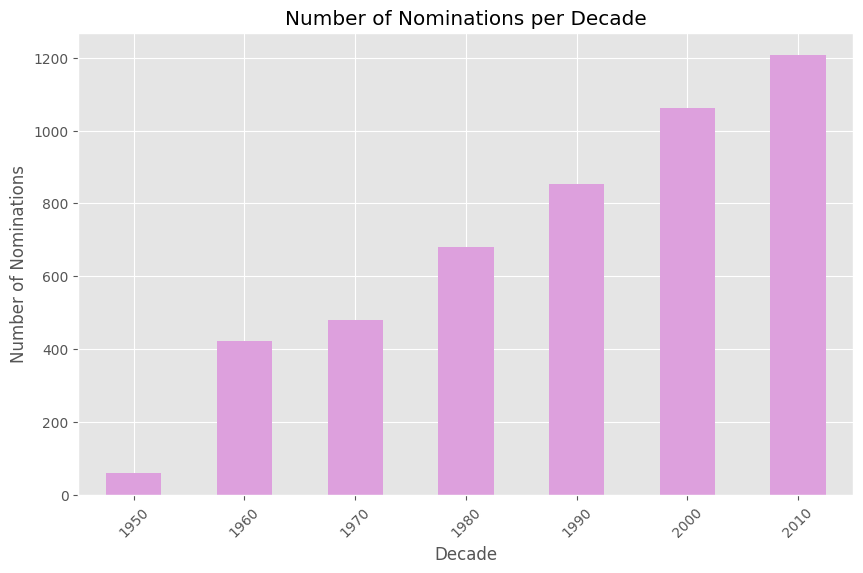

In [53]:
nominations_per_decade = awarded_data["decade"].value_counts().sort_index()

plt.figure(figsize=(10, 6))

nominations_per_decade.plot(kind="bar", color="plum")

plt.title("Number of Nominations per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Nominations")

plt.xticks(rotation=45)

plt.show()

### **Most Nominated Artists per Decade**

The graph shows that certain artists have dominated the nominations during specific periods. For instance, in the 1980s, the most nominated artist was Michael Jackson, while in the 2010s, Adele led the nominations. This analysis highlights how the popularity and recognition of artists can vary significantly from one decade to another.

18/09/2024 06:27:49 PM Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
18/09/2024 06:27:49 PM Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


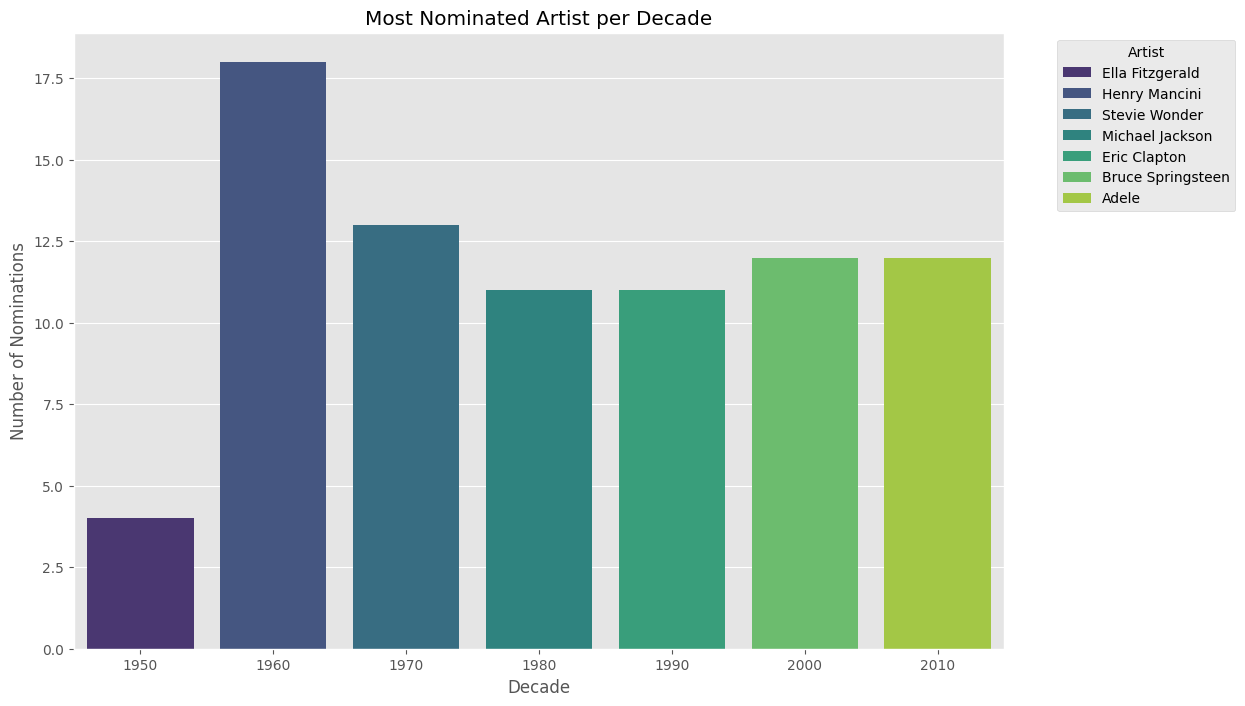

In [54]:
filtered_awarded_data = awarded_data[awarded_data["artist"] != "Various Artists"]

most_nominated_per_decade = (filtered_awarded_data.groupby(["decade", "artist"])
                             .size()
                             .reset_index(name="count")
                             .sort_values(["decade", "count"], ascending=[True, False])
                             .drop_duplicates(subset=["decade"]))

plt.figure(figsize=(12, 8))

sns.barplot(x="decade",
            y="count",
            hue="artist",
            dodge=False,
            data=most_nominated_per_decade,
            palette="viridis")

plt.title("Most Nominated Artist per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Nominations")
plt.legend(title="Artist", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

### **Artists with the Most Nominations**

At the top of the list, "Various Artists" stands out significantly with over 100 nominations, indicating that collaborative or compilation albums are highly nominated in the Grammy Awards. The Chicago Symphony Orchestra, John Williams, and Henry Mancini follow, each with substantial nominations ranging from 30 to 40.

Classical music is well represented in this chart, with several prominent figures like the Chicago Symphony Orchestra and Vladimir Horowitz. Additionally, legendary pop and rock artists such as Bruce Springsteen, U2, and Stevie Wonder make the list, showcasing their enduring influence and contribution to music over time.

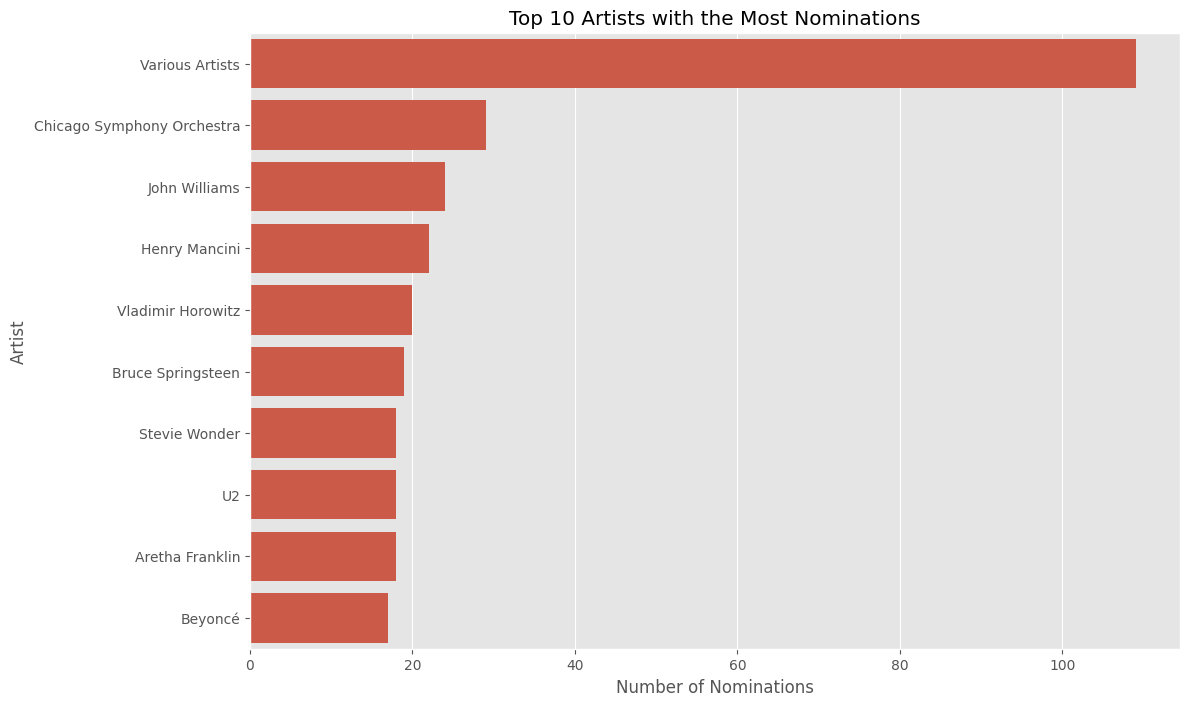

In [55]:
artist_nominations = awarded_data["artist"].value_counts().head(10)

plt.figure(figsize=(12, 8))

sns.barplot(x=artist_nominations.values,
            y=artist_nominations.index)

plt.title("Top 10 Artists with the Most Nominations")
plt.xlabel("Number of Nominations")
plt.ylabel("Artist")

plt.show()

### **Evolution of the Number of Categories per Year**

From the 1960s to 2010, there is a clear upward trend, reflecting a steady increase in the number of categories, reaching over 100 in the late 2000s. However, a sharp decline occurs in 2011, where the number of categories significantly drops.

This sudden decrease is attributed to a major reorganization implemented by the Recording Academy in 2011-2012. During this years, the number of categories was reduced from 109 to 78 in an effort to streamline the awards, combining several categories that were either too specific or overlapping. The goal was to make the awards more relevant to contemporary music.

Following the reorganization, the number of categories has remained relatively stable, suggesting that the Recording Academy has maintained this streamlined structure in subsequent years.

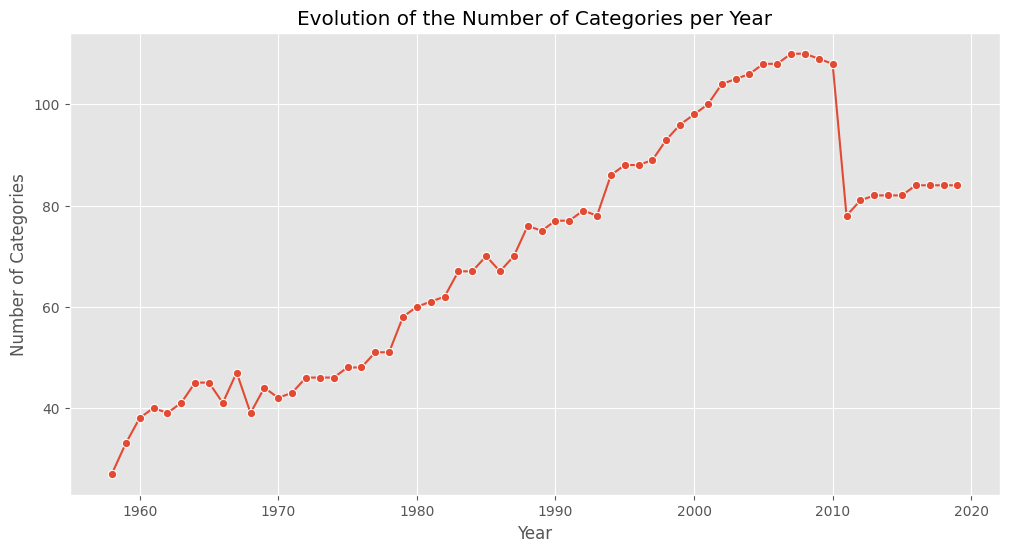

In [56]:
categories_per_year = awarded_data.groupby("year")["category"].nunique()

plt.figure(figsize=(12, 6))

sns.lineplot(x=categories_per_year.index, y=categories_per_year.values, marker="o")

plt.title("Evolution of the Number of Categories per Year")
plt.xlabel("Year")
plt.ylabel("Number of Categories")

plt.show()

## ***Conclusions***
---

- **Data Cleaning and Preparation:**
    - The dataset required significant cleaning, particularly in handling null values in the `artist` and `workers` columns.
    - Columns such as `published_at`, `updated_at` and `img` were deemed unnecessary and removed to streamline the dataset.
    - Instead, the `winner` column was left, under a new name such as `is_nominated`.

- **Handling Null Values:**
    - Various strategies were employed to handle null values, including dropping rows with null `nominee` values and imputing `artist` values from the `workers` column.
    - Specific patterns in the `workers` column were identified and used to extract missing `artist` information.

- **Data Transformation:**
    - The `artist` column was standardized by replacing inconsistent entries like "(Various Artists)" with "Various Artists".
    - A new `decade` column was added to facilitate analysis over different time periods.

- **Analysis Insights:**
    - The number of Grammy nominations has steadily increased over the decades, peaking in the 2010s.
    - Certain artists dominated the nominations in specific decades, reflecting changes in musical trends and popularity.
    - Collaborative or compilation albums, represented by "Various Artists", received the highest number of nominations.
    - The number of Grammy categories has evolved over the years, with a significant reorganization in 2011-2012 to streamline the awards.

- **Visualization:**
    - Bar plots and line plots were used to visualize the number of nominations per decade, the most nominated artists per decade, and the evolution of Grammy categories over the years.
    - These visualizations provided clear insights into trends and patterns within the Grammy Awards data.